In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 80
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit

def objective(x, a, b, c):
    return a * x + b * x**2 + c

def c_of_c_test(r, n, a):
    t_value = r * ((n-2)/(1 - r**2)) ** 0.5
    t_critical = stats.t.ppf(1 - a/2, n - 2)
    pval = stats.t.sf(np.abs(t_value), n - 2)*2
    print('r = ', r)
    print('t_critical = ', t_critical)
    print('t = ', t_value)
    print('p_value = ', pval)
    return t_value

def CI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    #point prediction value
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core1 = (1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) /    cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
    CI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return CI

def PI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    print("make prediction at new x = ", x1)
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core2 = (1 + 1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core2
    PI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% prediction interval: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return PI

def Chi_Square_for_Normality(SD, N, a): 
    m = np.mean(SD)
    s = np.std(SD)   
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s 
    counts, bins = np.histogram(SD, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
        chi_pval = -99999 # Invalid
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e) 
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
#         print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = N - 3
    crit_value = stats.chi2.ppf(1 - a, df)
#     print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    return chi_pval


def Randomness(SD):
    print('Randomness Test using Runs Test')
    print(' - H0: Randomness exists.')
    print(' - H1: Randomness does not exist\n')
    
    SD_median = statistics.median(SD)
    
    runs, n1, n2 = 1, 0, 0
    if(SD[0]) >= SD_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(1,len(SD)): 
        # no. of runs 
        if (SD[i] >= SD_median and SD[i-1] < SD_median) or (SD[i] < SD_median and SD[i-1] >= SD_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(SD[i]) >= SD_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    if n1>20 or n2>20:
        print('\nruns_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z)
        
        if pval_z < 0.05:
            print('\nSince p-value < 0.05, we reject H0 and conclude randomness does not exist.')
        else:
            print('\nSince p-value > 0.05, we do not reject H0 and we may conclude randomness exists.')
    else:
        print('Since both n1 and n2 < 20, we check the Run Test table.')
def Homoscedasticity(data, xlabel):
    print('Homoscedasticity Test')
    print(' - H0: Homoscedasticity')
    print(' - H1: Heteroscedasticity\n')
    y_pre = data[:, 2]
    SD = data[:, 10]
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(xlabel)
    plt.ylabel('Standardized Residual')
    plt.show()

def Normality(SD):
    print('Normality test for errors using Shapiro Test or Chi-square Test')
    print(' - H0: Errors are normally distributed.')
    print(' - H1: Errors are not normally distributed.\n')
    stat, p = stats.shapiro(SD)
    chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
    print('pvalue of Chi square =', chi2_pval)
    print('pvalue of Shapiro Test =', p)
    if p > 0.05:
        print('\nSince p-value (shapiro) > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
    elif chi2_pval > 0.05:
         print('\nSince p-value (chi square) > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
    else:
        print('\nSince p-value < 0.05, we reject H0 and conclude errors are not normally distributed.')

def Outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    ids = outliers.index
    ids = [n+1 for n in ids]
    
    print("Outliers by SD = \n")
    print(outliers)
    
    if len(ids)== 0:
        print("\nThere isnt any oulier.")
    else:
        print("\nSample", ids, "are outliers.")
        
def Influential(x_data, y_data):
    x_data = x_data.values
    y_data = y_data.values
    cov_mat = np.cov(y_data, x_data)
    x_data_bar = x_data.mean()
    data_nobs = len(x_data)
    h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat[1,1]
    df = pd.DataFrame(h_val,columns = ['hi'])
    filter = (df['hi'] > 6 / data_nobs )
    influs = df['hi'].loc[filter]
    ids = influs.index
    ids = [n+1 for n in ids]
    
    print("Influential Observations by hi = \n")
    print(influs)
    
    if len(ids)== 0:
        print("\nThere isnt any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")

def CI_PI_regression(xdata, yval, x1, a):
    print("make CI and PI prediction at mean of x = ", x1)
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5
    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI

def Durbin_Watson_test(x,dl,du):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print(f"According to table of Durbin-Watson test, dL is {dl}, dU is {du}. d is {d:.4f}.")
    print("\nConduct Autocorrelation test")
    print("H0: The data are not positively first-order correlated.")
    print("H1: The data are positively first-order correlated.\n")
    if d < dl:
        print("d < dL. H0 is rejected.There is enough evidence to show that positive first-order correlation exists.")
    elif d > du:
        print("d > dU. H0 is not rejected.There is not enough evidence to show that positive first-order correlation exists.")
    elif (d > dl and d <du):
        print("The test is inconclusive.")
    print("\nH0: The data are not negatively first-order correlated.")
    print("H1: The data are negatively first-order correlated.\n")
    if d > 4-dl:
        print("d > 4 - dL. H0 is rejected.There is enough evidence to show that negative first-order correlation exists.")
    elif d < 4-du:
        print("d < 4 - dU. H0 is not rejected.There is not enough evidence to show that negative first-order correlation exists.")
    elif (d < 4 - dl and d  > 4 - du):
        print("The test is inconclusive.")

def Model_Assess(result_reg, ydata, ylabel):
    print("Check Standard error")
    print("standard error = ", result_reg.mse_resid ** 0.5)
    print("mean of y", ydata.mean())
    print("std of y", ydata.std())
    
    print("\n Check R-squared")
    print("R-squared = ", result_reg.rsquared)
    print("Adjusted R-squared = ", result_reg.rsquared_adj)
    print(f"{result_reg.rsquared*100:.4f}% of variation in {ylabel} is explained by the variations in independent variables. The rest remains unexplained.")
    if(result_reg.rsquared - result_reg.rsquared_adj < 0.06):
        print("The gap between R-squared and Adjusted R-squared is smaller than 0.06, The model is fine.")
    else:
        print("The gap between R-squared and Adjusted R-squared is bigger than 0.06, There may be overfitting.")
    
    print("\n Conduct F test")
    f_res = result_reg.fvalue
    print("F value = ", f_res)
    MSE = result_reg.mse_resid
    df_model = result_reg.df_model
    df_error = result_reg.df_resid
    MSR = f_res * MSE
    SSR = MSR * df_model
    print("SSR = ", SSR, "df = ", df_model, "MSR = ", MSR)
    print("SSE = ", MSE * df_error, "df = ", df_error, "MSE = ", MSE)
    print("F = ", MSR / MSE)
    A = np.identity(len(result_reg.params))
    A = A[1:,:]
    print("F test = ", result_reg.f_test(A))
    print("F p-value = ", result_reg.f_pvalue)
    if( result_reg.f_pvalue < 0.05):
        print("Since p-value is smaller than 0.05, H0 is rejected. The model is valid.")
    else:
        print("Since p-value is bigger than 0.05, H0 is not rejected. The model is not valid.")
    
    print("\n Conduct T test")
    to_t = result_reg.pvalues.reset_index()
    for i in range(1,len(to_t)):
        if to_t[0][i] < 0.05:
            print(f"The pvalue of {to_t['index'][i]} is smaller than 0.05, H0 is rejected. {to_t['index'][i]} is related to {ylabel}")
        else:
            print(f"The pvalue of {to_t['index'][i]} is bigger than 0.05, H0 is not rejected. {to_t['index'][i]} is not related to {ylabel}")
def Print(result_reg):
    To_Print = result_reg.params.reset_index()
    print("Estimated model: y = ", end='')
    for i in range(len(To_Print)):
        if i == 0:
            print(f"{To_Print[0][i]:.4f}", end='')
        else:
            if To_Print[0][i] >= 0:
                print(" + ", end='')
            else:
                print(" ", end='')
            print(f"{To_Print[0][i]:.4f} {To_Print['index'][i]}", end='')
    
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()
    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []
        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]
        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)
        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected
        candidates = set(candidates) - set(selected)
        candidates = list(candidates)
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary()) 
    
def influential_multi(X_data,df,data):
    # hi 
    X = np.array(X_data)
    H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
    df['hii'] = np.diagonal(H)
    df_h = pd.DataFrame(df['hii'])
    k = result_reg.df_model
    n = len(df_h['hii'])
    h_level = 3 * (k+1) / n 
    print("h_level = ", h_level)
    print(" \n")
    filter = (df_h['hii'] > h_level )
    influs = df_h['hii'].loc[filter]
    print("Influential Observations by hi = \n")
    print(influs)
    ids = influs.index
    ids = [n+1 for n in ids]
    
    if len(ids)== 0:
        print("\nThere isnt any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")

    # cooks
    s2_e = result_reg.mse_resid
    k = result_reg.df_model
    y_a = data[:, 1]
    y_f = data[:, 2]
    h_i = df['hii']
    CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * h_i / np.square(1 - h_i)
    CD = np.array(CD_arr)
    df_cd = pd.DataFrame(CD,columns = ['CD'])
    display(df_cd.head())
    filter = (df_cd['CD'] > 1 )
    influs = df_cd['CD'].loc[filter]
    print("Influential Observations by Cook's Distances = \n")
    print(influs)
    ids = influs.index
    ids = [n+1 for n in ids]
    
    if len(ids)== 0:
        print("\nThere isn't any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")
def value_to_int(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return int(float(x.replace('K', '')) * 1000)
        return 1000
    if 'M' in x:
        if len(x) > 1:
            return int(float(x.replace('M', '')) * 1000000)
        return 1000000
    if 'B' in x:
        return int(float(x.replace('B', '')) * 1000000000)
    if ' ' in x:
        return int(float(x.replace(' ','')))
    return int(x)



=================================== Avg_Daily_Visitors - Facebook_likes ===================================




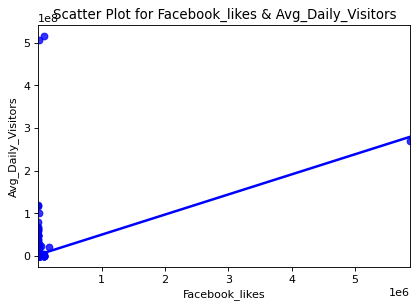

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     187.5
Date:                Sun, 22 May 2022   Prob (F-statistic):           2.79e-40
Time:                        02:39:24   Log-Likelihood:                -27051.
No. Observations:                1483   AIC:                         5.411e+04
Df Residuals:                    1481   BIC:                         5.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.628e+06   5.26e+05      4.

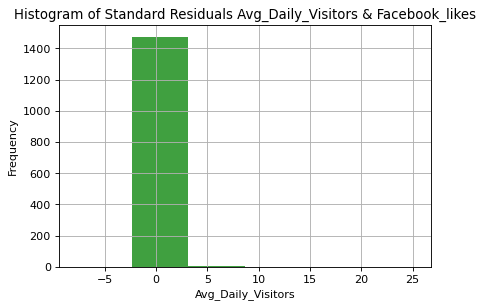

Shapiro Test
Statistics=0.098, p=0.000
Chi-squared test:
0.0


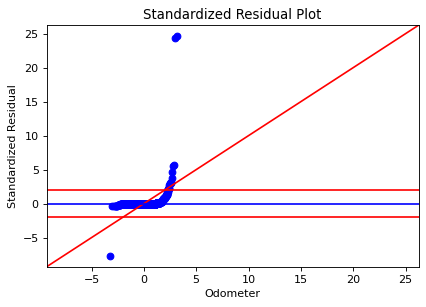

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  298
n1 =  742
n2 =  741

runs_exp =  742.4996628455833
stan_dev =  19.248363414968605
z =  -23.09285487097129
pval_z =  5.462392283224451e-118

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     25.116681
1     24.879196
2     -7.839999
3      5.624399
4      5.748741
5      4.753084
6      3.175641
7      3.800599
8      2.866942
9      3.020082
10     2.278956
11     3.071482
12     2.757912
13     2.153594
14     2.250919
15     2.235249
16     2.192857
Name: SD, dtype: float64

Influential Observations 

[9.03595271e-04 6.76298160e-04 9.96563195e-01 ... 6.75094771e-04
 6.75092360e-04 6.75019433e-04]
Influential Observations by hi = 

2    0.996563
Name: hi, dtype: float64
MSE:  409345482822249.44
Standard errors:  20232288.126216706


Coefficient of determination:

SSR =  6.062406600597514e+17
R2 =  0.11239419506359305


Coefficient of

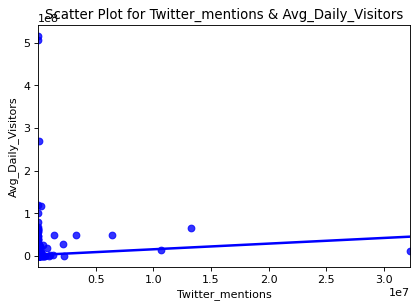

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.437
Date:                Sun, 22 May 2022   Prob (F-statistic):            0.00644
Time:                        02:39:24   Log-Likelihood:                -37960.
No. Observations:                2093   AIC:                         7.592e+04
Df Residuals:                    2091   BIC:                         7.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.233e+06   3.99e+05  

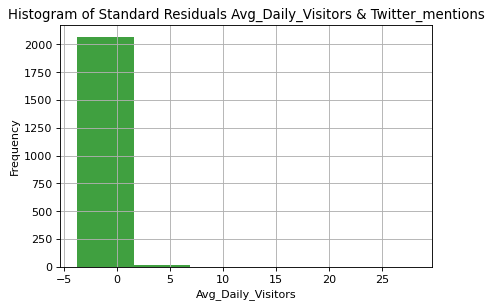

Shapiro Test
Statistics=0.086, p=0.000
Chi-squared test:
0.0


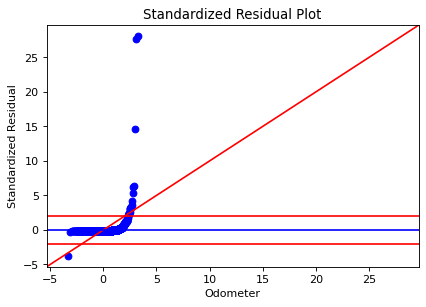

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  368
n1 =  1047
n2 =  1046

runs_exp =  1047.4997611084568
stan_dev =  22.86918541631109
z =  -29.712460183379083
pval_z =  5.3008945559443673e-194

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     28.146424
1     27.676704
2     14.697491
3      6.248147
4      6.405242
5      5.343048
6      3.551589
7      4.241324
8      3.203974
9      3.374521
10     2.121063
11     2.634069
12     3.083591
13     3.301556
14     2.414264
15     2.982939
16     2.426297
17     2.271674
18     2.456279
19     2.061965
20     2.007526
92    -3.754120
Name: SD, dtype: float64

Influential Observations 

[0.0004784  0.0004782  0.00047819 ... 0.00047896 0.00047896 0.00047896]
Influential Observations by hi = 

10     0.029435
11     0.125970
17     0.008107
32     0.003534
54     0.081580
92     0.743298
121    0.003962
Name: hi, dtype: float64
MSE:  332

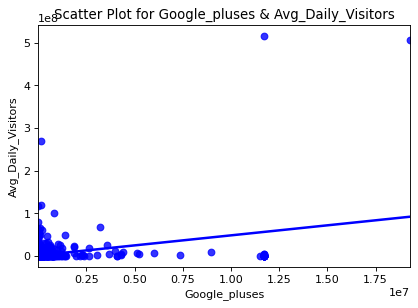

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     351.6
Date:                Sun, 22 May 2022   Prob (F-statistic):           5.34e-74
Time:                        02:39:25   Log-Likelihood:                -50344.
No. Observations:                2807   AIC:                         1.007e+05
Df Residuals:                    2805   BIC:                         1.007e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.108e+06   2.84e+05      3.904

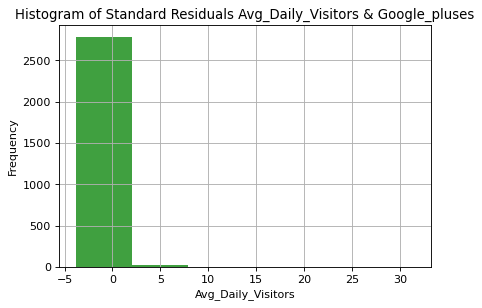

Shapiro Test
Statistics=0.125, p=0.000
Chi-squared test:
0.0


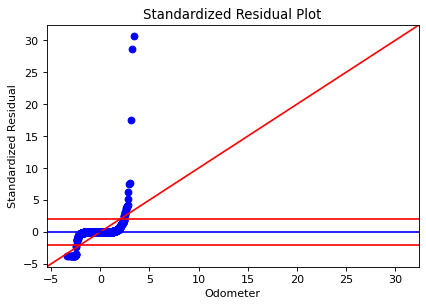

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  692
n1 =  1404
n2 =  1403

runs_exp =  1404.4998218738867
stan_dev =  26.4858402316993
z =  -26.90115985148694
pval_z =  2.1286569771625888e-159

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       31.406337
1       29.403098
2       18.017639
3        7.736819
4        7.869984
5        6.359014
6        3.410139
7        5.262742
8        3.936999
9        4.202921
10       3.169833
11       4.252379
12       3.846906
13       4.113719
14       2.882206
15       3.716753
16       3.147828
17       2.699968
18       3.079443
19       2.597480
20       2.531009
23       2.490514
123     -2.382327
183     -3.533729
196     -3.476166
265     -3.620386
339     -2.287701
356     -3.722204
597     -3.766724
818     -3.801386
1132    -3.837705
1237    -3.776041
1534    -3.815258
1615    -3.839883
1908    -3.840814
2278    -3.841994
2295    -3.8

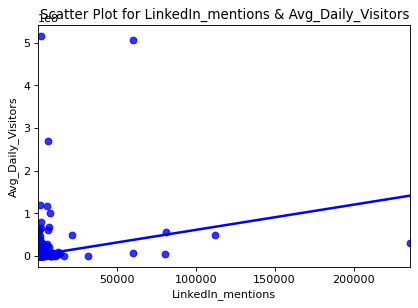

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     100.7
Date:                Sun, 22 May 2022   Prob (F-statistic):           3.63e-23
Time:                        02:39:25   Log-Likelihood:                -37700.
No. Observations:                2081   AIC:                         7.540e+04
Df Residuals:                    2079   BIC:                         7.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.977e+06   3.93e+0

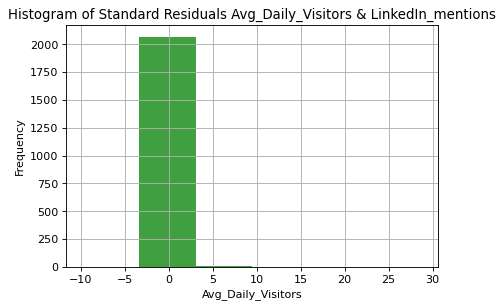

Shapiro Test
Statistics=0.095, p=0.000
Chi-squared test:
0.0


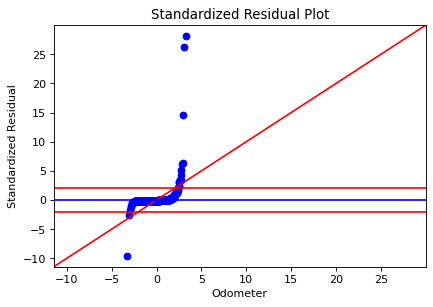

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  514
n1 =  1041
n2 =  1040

runs_exp =  1041.4997597308986
stan_dev =  22.80350059834276
z =  -23.13240274035972
pval_z =  2.1861169084775156e-118

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0      28.681946
1      26.791239
2      14.813524
3       6.232175
4       6.509539
5       5.219944
6       3.415673
7       4.279569
8       3.072688
9       3.445274
11      3.452500
12      3.150498
13      3.368562
14      2.442243
17      2.518562
18      2.117552
19      2.027386
22      2.016221
23     -9.784611
122    -2.611472
Name: SD, dtype: float64

Influential Observations 

[0.00049181 0.03874921 0.00081865 ... 0.00048488 0.00048054 0.0004848 ]
Influential Observations by hi = 

1      0.038749
10     0.135188
15     0.070448
16     0.005113
23     0.602273
122    0.069579
124    0.010954
126    0.039137
677    0.003244
Name: hi, dtype

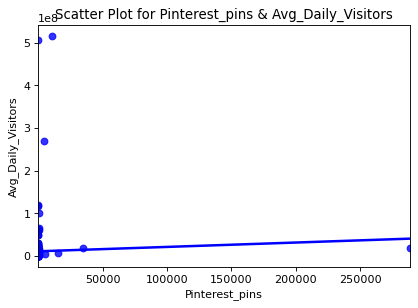

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3644
Date:                Sun, 22 May 2022   Prob (F-statistic):              0.547
Time:                        02:39:25   Log-Likelihood:                -4974.5
No. Observations:                 260   AIC:                             9953.
Df Residuals:                     258   BIC:                             9960.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.076e+07   3.08e+06      3.

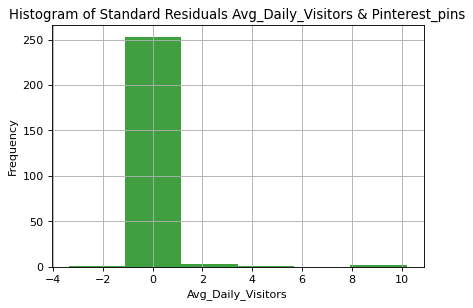

Shapiro Test
Statistics=0.220, p=0.000
Chi-squared test:
8.658939836979966e-197


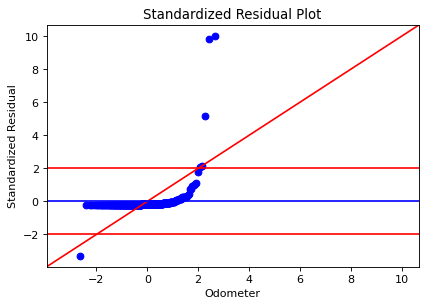

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  26
n1 =  130
n2 =  130

runs_exp =  131.0
stan_dev =  8.04667849171537
z =  -13.048862348372063
pval_z =  6.450340553290777e-39

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     10.187099
1     10.031209
2      5.239121
3      2.137727
4      2.188750
26    -3.371624
Name: SD, dtype: float64

Influential Observations 

[0.00488826 0.00386805 0.00393496 0.00386906 0.00386942 0.0038574
 0.00385544 0.00386952 0.0038661  0.00385308 0.00386939 0.00386841
 0.00386949 0.00386629 0.00386919 0.00386956 0.00386825 0.00386669
 0.00386949 0.00386952 0.00386764 0.00386466 0.00386877 0.00386952
 0.00386767 0.00386867 0.98105174 0.00386789 0.00386939 0.00386949
 0.01717813 0.00385195 0.00386956 0.00386939 0.00386919 0.00386767
 0.00386114 0.00386952 0.00386942 0.00386906 0.00386956 0.00386949
 0.00386956 0.00386825 0.00386949 0.00386923 0.00386926 0.00

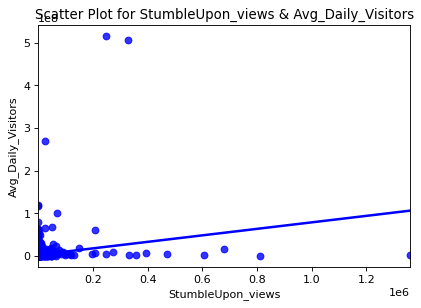

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     66.31
Date:                Sun, 22 May 2022   Prob (F-statistic):           7.44e-16
Time:                        02:39:26   Log-Likelihood:                -30710.
No. Observations:                1685   AIC:                         6.142e+04
Df Residuals:                    1683   BIC:                         6.144e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.406e+06   4.89e+0

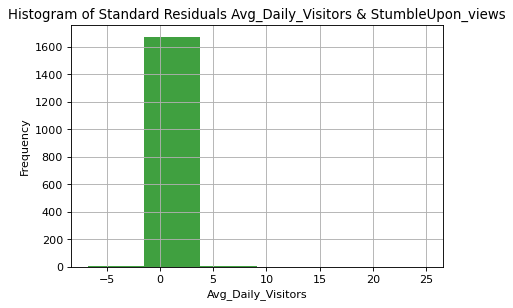

Shapiro Test
Statistics=0.120, p=0.000
Chi-squared test:
0.0


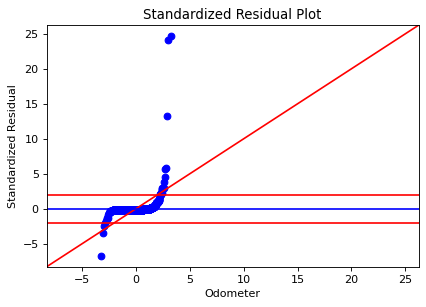

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  340
n1 =  843
n2 =  842

runs_exp =  843.4997032640949
stan_dev =  20.51827368001729
z =  -24.53908701658719
pval_z =  5.655955983610593e-133

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0      24.956834
1      24.332515
2      13.352360
3       5.721265
4       5.850635
5       4.617239
6       3.054772
7       3.870934
8       2.132312
9       3.078174
10      2.312015
11      3.032945
12      2.811600
13      3.011525
14      2.198189
15      2.706106
16      2.298082
17      2.280604
18      2.237347
257    -2.418438
354    -6.770892
488    -3.439031
Name: SD, dtype: float64

Influential Observations 

[0.01330962 0.02363128 0.00065725 ... 0.00060172 0.00060172 0.00060171]
Influential Observations by hi = 

0      0.013310
1      0.023631
8      0.009689
35     0.005042
54     0.100942
108    0.016451
138    0.034012
140    0.009511
1

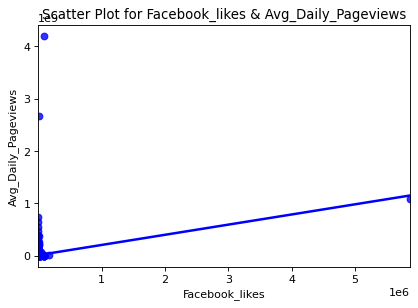

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.045
Model:                             OLS   Adj. R-squared:                  0.045
Method:                  Least Squares   F-statistic:                     70.14
Date:                 Sun, 22 May 2022   Prob (F-statistic):           1.26e-16
Time:                         02:39:26   Log-Likelihood:                -29879.
No. Observations:                 1483   AIC:                         5.976e+04
Df Residuals:                     1481   BIC:                         5.977e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.479e+07   3.54e+

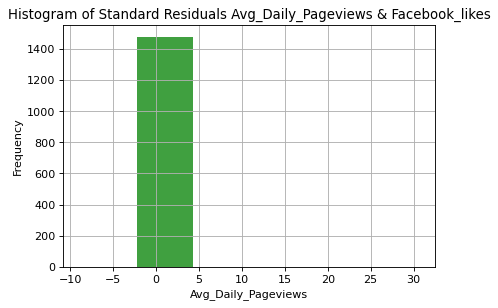

Shapiro Test
Statistics=0.078, p=0.000
Chi-squared test:
0.0


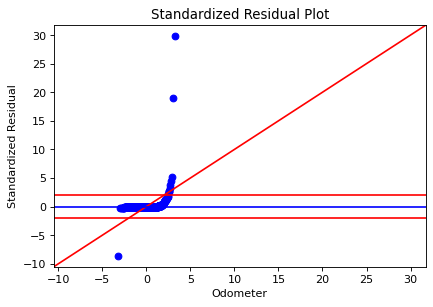

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  344
n1 =  742
n2 =  741

runs_exp =  742.4996628455833
stan_dev =  19.248363414968605
z =  -20.703041305614985
pval_z =  3.251877693709015e-95

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     30.566219
1     19.559626
2     -8.843454
3      5.339445
4      2.809385
5      2.683810
6      3.932083
7      2.198784
8      4.661684
10     2.822881
13     3.354404
Name: SD, dtype: float64

Influential Observations 

[9.03595271e-04 6.76298160e-04 9.96563195e-01 ... 6.75094771e-04
 6.75092360e-04 6.75019433e-04]
Influential Observations by hi = 

2    0.996563
Name: hi, dtype: float64
MSE:  1.853131575449611e+16
Standard errors:  136129775.4148449


Coefficient of determination:

SSR =  2.7444878632408744e+19
R2 =  0.04521995831908876


Coefficient of correlation:

r =  0.2126498490925597
t_critical =  1.961567075831078
t =  8.375118142157676

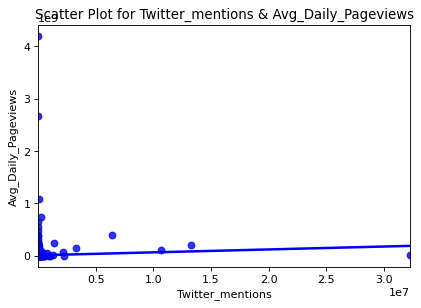

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     3.141
Date:                 Sun, 22 May 2022   Prob (F-statistic):             0.0765
Time:                         02:39:27   Log-Likelihood:                -41861.
No. Observations:                 2093   AIC:                         8.373e+04
Df Residuals:                     2091   BIC:                         8.374e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.17e+07   

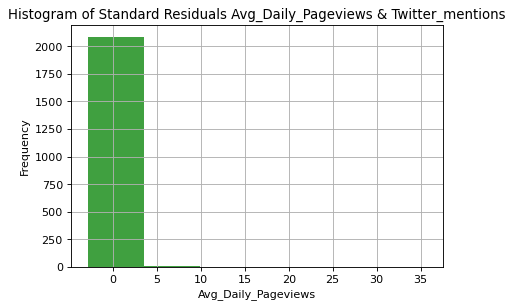

Shapiro Test
Statistics=0.063, p=0.000
Chi-squared test:
0.0


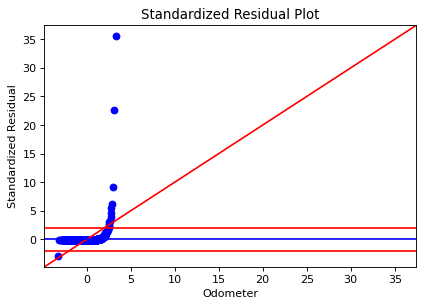

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  456
n1 =  1047
n2 =  1046

runs_exp =  1047.4997611084568
stan_dev =  22.86918541631109
z =  -25.864487533805153
pval_z =  1.6719647772197307e-147

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     35.586683
1     22.706628
2      9.116531
3      6.200231
4      3.281628
5      3.163724
6      4.584161
7      2.573605
8      5.426236
9      2.096857
10     3.040741
12     2.038437
14     3.913272
22     2.208246
92    -2.872730
Name: SD, dtype: float64

Influential Observations 

[0.0004784  0.0004782  0.00047819 ... 0.00047896 0.00047896 0.00047896]
Influential Observations by hi = 

10     0.029435
11     0.125970
17     0.008107
32     0.003534
54     0.081580
92     0.743298
121    0.003962
Name: hi, dtype: float64
MSE:  1.380599644768292e+16
Standard errors:  117498921.0490161


Coefficient of determination:

SSR =  2.886833857210498

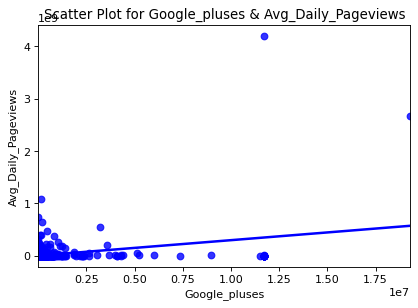

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.106
Model:                             OLS   Adj. R-squared:                  0.105
Method:                  Least Squares   F-statistic:                     331.7
Date:                 Sun, 22 May 2022   Prob (F-statistic):           3.81e-70
Time:                         02:39:27   Log-Likelihood:                -55580.
No. Observations:                 2807   AIC:                         1.112e+05
Df Residuals:                     2805   BIC:                         1.112e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.015e+06   1.83e+06 

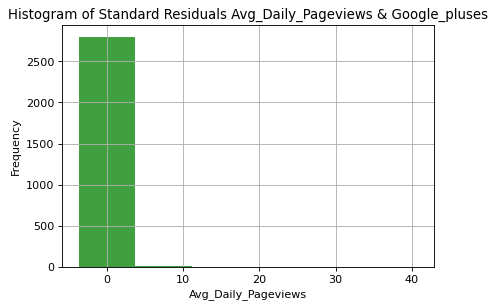

Shapiro Test
Statistics=0.102, p=0.000
Chi-squared test:
0.0


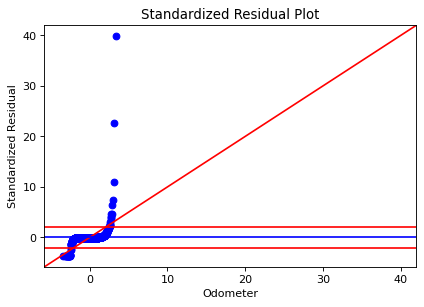

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  838
n1 =  1404
n2 =  1403

runs_exp =  1404.4998218738867
stan_dev =  26.4858402316993
z =  -21.38878045469282
pval_z =  1.6994383152701704e-101

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       40.714390
1       23.111954
2       11.166940
3        7.652125
4        4.038222
5        3.688335
6        4.688840
7        3.211927
8        6.639840
9        2.630055
10       4.066748
11       2.074761
12       2.558587
14       4.706213
16       2.410011
20       2.041538
21       2.178764
22       2.447293
25       2.091085
123     -2.557836
183     -3.565075
196     -3.638818
265     -3.640231
339     -2.254899
356     -3.670337
597     -3.691965
818     -3.699084
1132    -3.711059
1237    -3.647609
1534    -3.703377
1615    -3.711762
1908    -3.712021
2278    -3.712329
2295    -3.712335
2409    -3.709289
2498    -3.709045
2680    -3.7

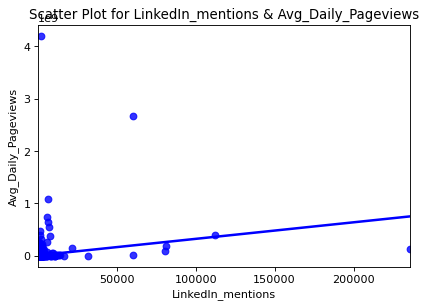

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.032
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     67.94
Date:                 Sun, 22 May 2022   Prob (F-statistic):           2.95e-16
Time:                         02:39:27   Log-Likelihood:                -41595.
No. Observations:                 2081   AIC:                         8.319e+04
Df Residuals:                     2079   BIC:                         8.320e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.04e+07

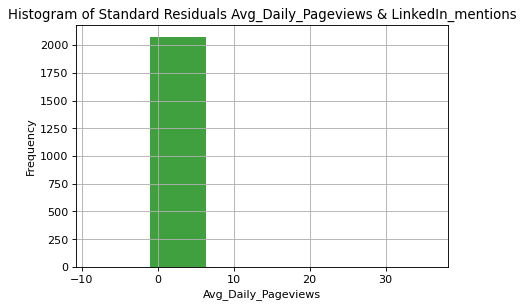

Shapiro Test
Statistics=0.071, p=0.000
Chi-squared test:
0.0


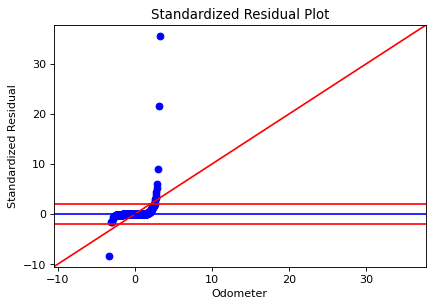

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  596
n1 =  1041
n2 =  1040

runs_exp =  1041.4997597308986
stan_dev =  22.80350059834276
z =  -19.53646361485724
pval_z =  5.37818264547361e-85

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     36.004047
1     21.797093
2      9.078558
3      6.156856
4      3.300736
5      3.012028
6      4.470688
7      2.565821
8      5.333131
9      2.124286
12     2.066873
14     3.944720
21     2.090937
23    -8.461189
Name: SD, dtype: float64

Influential Observations 

[0.00049181 0.03874921 0.00081865 ... 0.00048488 0.00048054 0.0004848 ]
Influential Observations by hi = 

1      0.038749
10     0.135188
15     0.070448
16     0.005113
23     0.602273
122    0.069579
124    0.010954
126    0.039137
677    0.003244
Name: hi, dtype: float64
MSE:  1.3462793988311138e+16
Standard errors:  116029280.73685168


Coefficient of determination:

SSR =  2.7

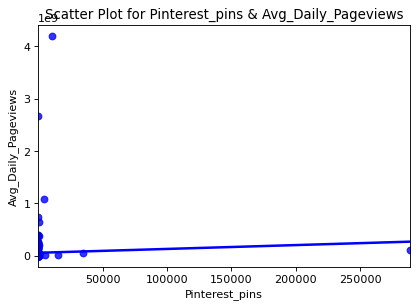

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.4375
Date:                 Sun, 22 May 2022   Prob (F-statistic):              0.509
Time:                         02:39:28   Log-Likelihood:                -5462.5
No. Observations:                  260   AIC:                         1.093e+04
Df Residuals:                      258   BIC:                         1.094e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5.919e+07   2.01e+

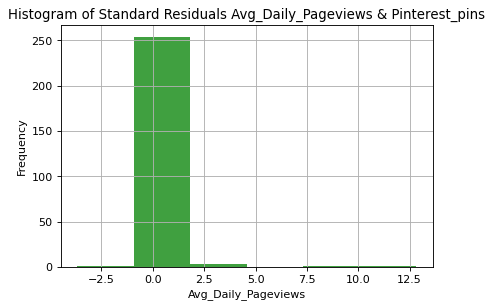

Shapiro Test
Statistics=0.185, p=0.000
Chi-squared test:
1.150859582663572e-205


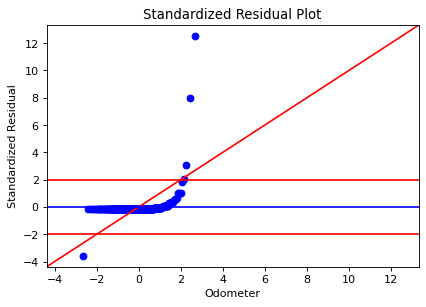

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  40
n1 =  130
n2 =  130

runs_exp =  131.0
stan_dev =  8.04667849171537
z =  -11.309014035255787
pval_z =  1.1841263859649912e-29

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0     12.786888
1      8.117195
2      3.162627
3      2.113860
26    -3.669064
Name: SD, dtype: float64

Influential Observations 

[0.00488826 0.00386805 0.00393496 0.00386906 0.00386942 0.0038574
 0.00385544 0.00386952 0.0038661  0.00385308 0.00386939 0.00386841
 0.00386949 0.00386629 0.00386919 0.00386956 0.00386825 0.00386669
 0.00386949 0.00386952 0.00386764 0.00386466 0.00386877 0.00386952
 0.00386767 0.00386867 0.98105174 0.00386789 0.00386939 0.00386949
 0.01717813 0.00385195 0.00386956 0.00386939 0.00386919 0.00386767
 0.00386114 0.00386952 0.00386942 0.00386906 0.00386956 0.00386949
 0.00386956 0.00386825 0.00386949 0.00386923 0.00386926 0.00386295
 0.00386

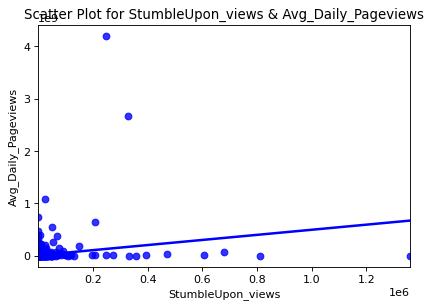

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.037
Model:                             OLS   Adj. R-squared:                  0.037
Method:                  Least Squares   F-statistic:                     64.82
Date:                 Sun, 22 May 2022   Prob (F-statistic):           1.54e-15
Time:                         02:39:28   Log-Likelihood:                -33852.
No. Observations:                 1685   AIC:                         6.771e+04
Df Residuals:                     1683   BIC:                         6.772e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.237e+07

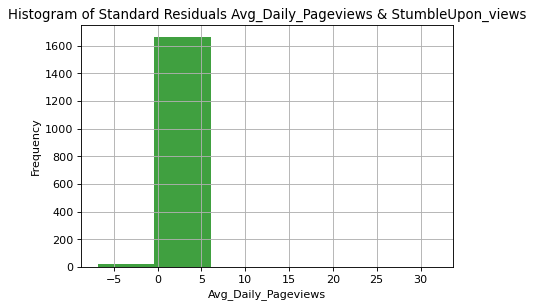

Shapiro Test
Statistics=0.097, p=0.000
Chi-squared test:
0.0


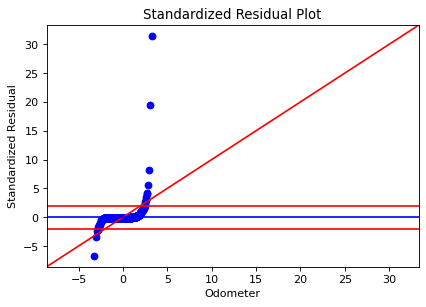

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  434
n1 =  843
n2 =  842

runs_exp =  843.4997032640949
stan_dev =  20.51827368001729
z =  -19.957804913329817
pval_z =  1.2822201204543682e-88

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0      31.794171
1      19.733305
2       8.243185
3       5.670328
4       2.994315
5       2.626906
6       4.001713
7       2.346948
8       4.182811
10      2.992681
14      3.570056
54     -2.249801
257    -2.376210
354    -6.775941
488    -3.397427
Name: SD, dtype: float64

Influential Observations 

[0.01330962 0.02363128 0.00065725 ... 0.00060172 0.00060172 0.00060171]
Influential Observations by hi = 

0      0.013310
1      0.023631
8      0.009689
35     0.005042
54     0.100942
108    0.016451
138    0.034012
140    0.009511
144    0.013630
154    0.048556
160    0.008477
257    0.079849
306    0.003931
316    0.023774
323    0.028111
354    

In [2]:
df = pd.read_excel('output.xlsx')
# display(df)

avg_dailys = ['Avg_Daily_Visitors', 'Avg_Daily_Pageviews']
media = ['Facebook_likes', 'Twitter_mentions', 'Google_pluses', 'LinkedIn_mentions', 'Pinterest_pins', 'StumbleUpon_views']

r_sqr_out_ori = {}

for ad in avg_dailys:
    for md in media:
        print("\n\n=================================== " + ad + " - " + md + " ===================================\n\n")
        
        

        """ ============================== data arrangement ============================== """

        fb = df[df[md].str.contains("-")==False]
        fb = fb[[ad,md]]
        fb.reset_index(inplace = True, drop = True)
        fb.dropna(inplace=True)
        fb[md] = fb[md].apply(value_to_int)
        fb[ad] = fb[ad].apply(value_to_int)
        # display(fb)



        """ ============================== scatter plot ============================== """

        _ = sns.regplot(x=md, y=ad, data = fb, color = 'b', ci = None)
        plt.title('Scatter Plot for '+ md + ' & '+ ad)
        plt.xlabel(md)
        plt.ylabel(ad)
        plt.show()



        """ ============================== regression summary table ============================== """

        # Fit regression model 
        fb_result = smf.ols(ad + ' ~ ' + md, data=fb).fit()
        # Inspect the results
        print(fb_result.summary())

        b1 = fb_result.params[1]
        b0 = fb_result.params[0]

        print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
        print(f"The coefficients are {b0:.4f} and {b1:.4f}")

        print(fb_result.summary())
        r_sqr_out_ori[ad + " of " + md] = float("{:.2f}".format(fb_result.rsquared))

        """ ============================== standardized residual ============================== """

        # studentized residual
        print("\n\nStandardized Residuals:\n")
        st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
        SD = data1[:, 10]
        mu = np.mean(SD)
        sigma = np.std(SD)
        print(SD)
        print('mu = ', mu)
        print('sigma = ', sigma)



        """ ============================== normality test ============================== """

        # histogram and Q-Q plot
        print("\n\nNormality test:\n")
        counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
        plt.xlabel(ad)
        plt.ylabel('Frequency')
        plt.title('Histogram of Standard Residuals ' + ad + ' & ' + md)
        plt.grid(True)
        bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
        plt.show()
        fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

        # Shapiro test
        print('Shapiro Test')
        stat, p = stats.shapiro(SD)
        print('Statistics=%.3f, p=%.3f' % (stat, p))

        # chi^2 test
        chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
        print("Chi-squared test:")
        print(chi2_pval)



        """ ============================== Homoscedasticity & Heteroscedasticity ============================== """

        y_pre = data1[:, 2]
        plt.plot(y_pre, SD, 'o', color = 'gray')
        plt.axhline(y=0, color = 'blue')
        plt.axhline(y=2, color = 'red')
        plt.axhline(y=-2, color = 'red')
        plt.title('Standardized Residual Plot')
        plt.xlabel(md)
        plt.ylabel('Standardized Residual')
        plt.show()



        """ ============================== runs test ============================== """

        Randomness(SD)



        """ ============================== outliers & influential ============================== """

        # outliers
        fb_c = pd.DataFrame(SD,columns = ['SD'])
        filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
        print("Outliers by SD = \n")
        print(fb_c['SD'].loc[filter])

        # influential
        print("\nInfluential Observations \n")
        x_data = fb[md].values
        y_data = fb[ad].values
        cov_mat1 = np.cov(y_data, x_data)
        x_data_bar = x_data.mean()
        data_nobs = len(x_data)
        h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
        print(h_val)
        fb_h = pd.DataFrame(h_val,columns = ['hi'])
        filter = (fb_h['hi'] > 6 / data_nobs )
        print("Influential Observations by hi = \n")
        print(fb_h['hi'].loc[filter])



        """ ============================== standard errors ============================== """

        s2_e = fb_result.mse_resid
        print('MSE: ', s2_e)
        s_e = fb_result.mse_resid ** 0.5
        print('Standard errors: ', s_e)



        """ ============================== coefficient of determination ============================== """

        print("\n\nCoefficient of determination:\n")
        SSR = fb_result.ssr
        # SST = SSR + SSE
        R2 = fb_result.rsquared
        print("SSR = ", SSR)
        print("R2 = ", R2)



        """ ============================== coefficient of correlation ============================== """

        print("\n\nCoefficient of correlation:\n")
        cor_mat = np.corrcoef(fb[[ad, md]].values, rowvar = False)
        n = fb[ad].shape[0]
        # print(n)
        r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

        



In [3]:
print("\n\nR Squareds:\n")
for item, amount in r_sqr_out_ori.items():  # dct.iteritems() in Python 2
    print("{} {}".format(item, amount))



R Squareds:

Avg_Daily_Visitors of Facebook_likes 0.11
Avg_Daily_Visitors of Twitter_mentions 0.0
Avg_Daily_Visitors of Google_pluses 0.11
Avg_Daily_Visitors of LinkedIn_mentions 0.05
Avg_Daily_Visitors of Pinterest_pins 0.0
Avg_Daily_Visitors of StumbleUpon_views 0.04
Avg_Daily_Pageviews of Facebook_likes 0.05
Avg_Daily_Pageviews of Twitter_mentions 0.0
Avg_Daily_Pageviews of Google_pluses 0.11
Avg_Daily_Pageviews of LinkedIn_mentions 0.03
Avg_Daily_Pageviews of Pinterest_pins 0.0
Avg_Daily_Pageviews of StumbleUpon_views 0.04
